# FIT5147 Assessment 2 - Data Exploration and Visualisation
## United States Health Inequality data pre-processing

**Author: Graham Chester**

**Date: 24-Mar-2018**

This Jupyter notebook takes two main datasets (health by city, life expectancy by county), and two value-mapping datasets, and wrangles them into a single CSV file (health.csv) suitable for use by D3 visualisation.

The datasets used are:

1) Center for Disease control 500 Cities health data, sourced from CDC 500 Cities portal: https://chronicdata.cdc.gov/500-Cities/500-Cities-Local-Data-for-Better-Health-2017-relea/6vp6-wxuq

2) Life Expectancy by income dataset, sourced from the Health Inequality Project https://healthinequality.org/data/

3) City to lat, long, FIPS mapping dataset, sourced from SimpleMaps https://simplemaps.com/data/us-cities)

4) Commuting Zone to FIPS mapping dataset, sourced from IPUMS census data https://usa.ipums.org/usa/volii/1990LMAascii.txt

## Imports and convenient display settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import seaborn as sns

%matplotlib inline

# set Jupyter to display ALL output from a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# set pandas and numpy options to make print format nicer
pd.set_option('display.width',110); pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth', 200); pd.set_option('display.max_rows', 500)
np.set_printoptions(linewidth=100, threshold=5000, edgeitems=10, suppress=True)

## Read CDC 500 Cities health dataset, filter and reshape 
1) Read dataset with only required fields (for performance as dataset is 230MB)

2) Clean up data types, names and filter for required rows

3) Rename columns with more information for better display in d3

4) Pivot so there is one row per city with many measure

In [4]:
# only read in the required columns as dataset is large
columns = ['StateAbbr','StateDesc','CityName','GeographicLevel','Data_Value','Data_Value_Type','PopulationCount',
           'CityFIPS','Short_Question_Text', 'Category', 'Measure']

health_R = pd.read_csv('data/500_Cities.csv', dtype={'CityFIPS': str}, usecols=columns, na_filter=True)

# change the United States total row so it behaves like a state when visualising
health_R.loc[health_R.StateDesc=='United States', "CityName"] = "United States"
health_R.loc[health_R.StateDesc=='United States', "StateDesc"] = "Average"
health_R.shape
# health_R.head(1)

# we only need non-adusted numbers, and only for cities not electoral areas
health_F = health_R[(health_R.Data_Value_Type=='Crude prevalence') & 
                    (health_R.GeographicLevel.isin(['City','US'])) ]
health_F.shape

# pivot so that we have columns for all the health measures, instead of a row for each
health_P = pd.pivot_table(health_F, values='Data_Value', index=['StateDesc', 'CityName'], 
                          columns=['Short_Question_Text'], aggfunc=np.sum).reset_index()
health_P.shape

# merge with fields from original dataset to get overall health row
health = pd.merge(health_P, health_F[['StateDesc','CityName','CityFIPS','PopulationCount']].drop_duplicates(),
                  how='left', on=['StateDesc','CityName'])
health.shape
# health.head(2)

# subjectively assign weights to each preventative measure (negative), unhealthy behaviour and health outcome
weights = {
           'Health Insurance':        6,
           'Arthritis':               3,
           'Binge Drinking':          6,
           'High Blood Pressure':     7,
           'Taking BP Medication':    3,
           'Cancer (except skin)':   10,
           'Current Asthma':          4,
           'Coronary Heart Disease': 10,
           'Annual Checkup':         -3,
           'Cholesterol Screening':  -3,
           'Colorectal Cancer Screening': -2,
           'COPD'                       : 10,
           'Core preventive services for older men':   -3,
           'Core preventive services for older women': -3,
           'Current Smoking':         7,
           'Dental Visit':           -1,
           'Diabetes':                8,
           'High Cholesterol':        6,
           'Chronic Kidney Disease':  8,
           'Physical Inactivity':     3,
           'Mammography':            -2,
           'Mental Health':           6,
           'Obesity':                 7,
           'Pap Smear Test':         -2,
           'Sleep < 7 hours':         2,
           'Physical Health':         5,
           'Stroke':                  9,
           'Teeth Loss':              1,
          }

# calculate health score for a city as a rating with 0 (worst) to 100 (best)
columns = list(health_F.Short_Question_Text.unique())
health['health_score'] = health[columns].mul(pd.Series(weights), axis=1).sum(axis=1)

health['health_score'] = health.health_score - health.health_score.min()
health['health_score'] = (98 * (1 - health.health_score / health.health_score.max()) +1).astype(int)

health['Health Insurance'] = 100 - health['Health Insurance']

# population should be integer
health['PopulationCount'] = health.PopulationCount.astype(int)
# health.head(2)


(810103, 11)

(14028, 11)

(501, 30)

(501, 32)

## Highest correlated Health Measures

In [49]:
dfcorr = health.corr().round(3)
df = pd.DataFrame()
for i, col1 in enumerate(dfcorr.columns):
    for j, col2 in enumerate(dfcorr.columns):
        df = df.append({'col1':col1, 'col2': col2, 'cor': dfcorr.iloc[i,j]}, ignore_index=True)
df = df[(df.cor!=1) & (df.col2!='health_score')& (df.col1!='health_score')]
df = df.drop_duplicates(subset='cor', keep='first')
df['abs_cor'] = np.abs(df.cor)
df = df.sort_values('abs_cor', ascending=False)
df = df.drop("abs_cor",axis=1).reset_index()
df

,index,col1,col2,cor
0,205,Chronic Kidney Disease,Stroke,0.920
1,100,COPD,Coronary Heart Disease,0.913
2,505,High Blood Pressure,Stroke,0.904
3,325,Coronary Heart Disease,Stroke,0.900
4,592,Mental Health,Physical Health,0.894
5,190,Chronic Kidney Disease,Coronary Heart Disease,0.884
6,115,COPD,Stroke,0.883
7,202,Chronic Kidney Disease,Physical Health,0.880
8,387,Current Smoking,Teeth Loss,0.878
9,442,Diabetes,Physical Health,0.875


## Add City and county details to health dataframe for each city
1) Read US Cities data file. 

2) Append latitude, longitude, county FIPS to the above health dataframe (so can be joined with life dataframe)

In [15]:
# read us cities data
uscities = pd.read_csv('data/uscitiesLatLongFIPS.csv', dtype={'PlaceFP':str, 'county_fips':str})
# uscities.head(2)

# reformat fields to not lose leading zeroes, and to corrent spelling of prefixes
uscities['county_fips'] = uscities.county_fips.apply('{:0>5}'.format)
uscities['city_ascii']  = uscities.city_ascii.str.replace('Saint', 'St.')

# merge city details with health dataframe
health = pd.merge(health, uscities[['city_ascii', 'state_name','lat','lng', 'county_fips','county_name']], 
                  how='left', left_on=['StateDesc','CityName'], right_on=['state_name','city_ascii'])

# change lat and long onUnited States row so d3 can place properly on screen
health.loc[health.CityName=='United States', 'lat'] =  51.1
health.loc[health.CityName=='United States', 'lng'] = -92.3
health.shape
# health.head(2)

(501, 39)

## Read life expectancy by income dataset and pre-process
1) Read life expectancy by income range dataset

2) Rename colums for ease, and calculate various average life expectacies and disparity with income

In [16]:
# read into dataframe only the required columns
life = pd.read_csv('data/health_ineq_all_online_tables.csv', skiprows=6,
                   usecols=['cz','czname','statename','stateabbrv', 'le_agg_q1_F', 'le_agg_q2_F', 'le_agg_q3_F', 
                            'le_agg_q4_F', 'le_agg_q1_M', 'le_agg_q2_M', 'le_agg_q3_M', 'le_agg_q4_M', ])

# better names for colums for easier understanding in d3
life = life.rename(columns={'le_agg_q1_F': 'life_q1_f', 'le_agg_q2_F': 'life_q2_f', 
                            'le_agg_q3_F': 'life_q3_f', 'le_agg_q4_F': 'life_q4_f',
                            'le_agg_q1_M': 'life_q1_m', 'le_agg_q2_M': 'life_q2_m',
                            'le_agg_q3_M': 'life_q3_m', 'le_agg_q4_M': 'life_q4_m',})

# calculate average life expectancies for male, female, overall, and for top and bottom 25% income earners
life['expectancy_f'] = life[['life_q1_f', 'life_q2_f', 'life_q3_f', 'life_q4_f']].mean(axis=1).round(1)
life['expectancy_m'] = life[['life_q1_m', 'life_q2_m', 'life_q3_m', 'life_q4_m']].mean(axis=1).round(1)
life['expectancy_top25'] = (life['life_q4_f']/2 + life['life_q4_m']/2).round(1)
life['expectancy_bot25'] = (life['life_q1_f']/2 + life['life_q1_m']/2).round(1)
life['expectancy_avg'] = (life['expectancy_f']/2 + life['expectancy_m']/2).round(1)


# calculate the disparity in life expectancy between top and bottom income earners
life['disparity_m']  = (life['life_q4_m'] - life['life_q1_m']).round(1)
life['disparity_f']  = (life['life_q4_f'] - life['life_q1_f']).round(1)
life['disparity_avg']  = (life['expectancy_top25'] - life['expectancy_bot25']).round(1)
life = life.dropna(axis=0, how='all')
life.shape
# life.head(2)

(595, 20)

## Add county FIPS code to life expectancy dataset
1) Read commuting zone to county FIPS mapping dataset

2) Add county FIPS code to life expectancy data

3) Drop non-required fields

In [17]:
cz_FIPS = pd.read_csv('data/1990LMAascii.csv',sep='\t', dtype={'FIPS': str})
cz_FIPS = cz_FIPS[cz_FIPS['County Name'] != 'Market Area Total']
cz_FIPS['stateabbrv'] = cz_FIPS['County Name'].str[-2:]
cz_FIPS.shape
# cz_FIPS.head(2)

# life = pd.merge(life, cz_FIPS, how='left', left_on=['stateabbrv','cz'], right_on=['stateabbrv','LMA/CZ'])
life = pd.merge(life, cz_FIPS, how='left', left_on=['cz'], right_on=['LMA/CZ'])
# life.head(1)
life = life.drop(['Total Population', 'Labor Force','County Name','LMA/CZ'], axis=1)
life.shape
# life.head(2)

(3141, 6)

(2857, 22)

## Merge health and life expectancy datasets

1) Merge datasets by county - note that city level life expectancy data was not available, however in most relevant cases US counties are small and cover one or just a few similar cities.

2) Calculate the mean life expectancies for the United States row

3) Save to CSV

4) Check for any NaN values (should just be the US overall row)

In [18]:
# merge health and life datasets by county FIPS code
total = pd.merge(health, life, how='left', left_on=['county_fips'], right_on=['FIPS'])
total = total.sort_values(['CityName','StateDesc'])
total.index.name = 'id'

# calculate mean life expectancy data for United States overall
usa_means = life.mean(axis=0) 
total.loc[total.CityName=='United States', usa_means.index[1:-1]] = np.round(usa_means[1:-1].values,1)
total.loc[total.CityName=='United States'] = total.loc[total.CityName=='United States'].fillna('')
total.shape
# total.head(3)

# rename columns to include more details for d3 to display
new_columns = {'Annual Checkup':                          '1P:No Annual Checkup', 
               'Cholesterol Screening':                   '1P:No Cholesterol Screening',
               'Colorectal Cancer Screening' :            '1P:No Colorectal Cancer Screening', 
               'Core preventive services for older men':  '1P:No Preventive services-older men',
               'Core preventive services for older women':'1P:No Preventive services-older women',
               'Dental Visit':                            '1P:No Dental Visit',
               'Health Insurance':                        '1P:No Health Insurance',
               'Mammography':                             '1P:No Mammography',
               'Pap Smear Test':                          '1P:No Pap Smear Test',
               'Taking BP Medication':                    '1P:Not Taking BP Medication',
               'Binge Drinking':         '2B:Binge Drinking',
               'Current Smoking':        '2B:Current Smoking',
               'Obesity':                '2B:Obesity',
               'Physical Inactivity':    '2B:Physical Inactivity',
               'Sleep < 7 hours':        '2B:Sleep < 7 hours',
               'Arthritis':              '3O:Arthritis',
               'COPD':                   '3O:Chronic Pulmonary Disease',
               'Cancer (except skin)':   '3O:Cancer',
               'Chronic Kidney Disease': '3O:Chronic Kidney Disease',
               'Coronary Heart Disease': '3O:Coronary Heart Disease',
               'Current Asthma':         '3O:Asthma',
               'Diabetes':               '3O:Diabetes',
               'High Blood Pressure':    '3O:High Blood Pressure',
               'High Cholesterol':       '3O:High Cholesterol',
               'Mental Health':          '3O:Mental Health',
               'Physical Health':        '3O:Physical Health',
               'Stroke':                 '3O:Stroke',
               'Teeth Loss':             '3O:All Teeth Lost',
               'expectancy_top25':  '4L:Life Expectancy Top 25%:Life expectancy in years, Top Quartile Income',
               'expectancy_bot25':  '4L:Life Expectancy Bot 25%:Life expectancy in years, Bottom Quartile Income',
               'expectancy_avg':    '4l:LIFE EXPECTANCY AVERAGE: Average Life Expectancy in Years',
                }
total = total.rename(columns=new_columns)

# rename columns to include detailed description as appended to the above column name
lookup = health_F[['Short_Question_Text','Measure']] \
                    .drop_duplicates().sort_values(['Short_Question_Text'])
lookup['Short_Question_Text'] = lookup.Short_Question_Text.map(new_columns)
lookup['Measure'] = lookup['Short_Question_Text'] + ':' + lookup.Measure
lookup = lookup.set_index('Short_Question_Text')['Measure'].to_dict()
total = total.rename(columns=lookup)

# Calculate overall preventative measure score by city
preventatives = total.columns[total.columns.str[1:3]=='P:']
for p in preventatives:  # reverse sign of preventative measures so ALL higher scores are bad
    total[p] = (100 - total[p]).round(1)
total['1p:PREVENTATIVE MEASURES AVG:Average of all preventative measures'] = total[preventatives].mean(axis=1).round(1)

# Calculate overall unhealthy behaviours score by city
behaviours = total.columns[total.columns.str[1:3]=='B:']
total['2b:UNHEALTHY BEHAVIOURS AVG:Average of all unhealty behaviours']   = total[behaviours].mean(axis=1).round(1)

# Calculate overall health outcomes score by city
outcomes = total.columns[total.columns.str[1:3]=='O:']
total['3o:HEALTH OUTCOMES AVG:Average of all health outcomes']     = total[outcomes].mean(axis=1).round(1)

# save to CSV file for d3
total.to_csv('health.csv')

# check for any rows with NaNs, should just be a few fields on the United States row
total[total.isnull().any(axis=1)]

(501, 61)

,StateDesc,CityName,1P:No Annual Checkup:Visits to doctor for routine checkup within the past Year among adults aged >=18 Years,3O:Arthritis:Arthritis among adults aged >=18 Years,2B:Binge Drinking:Binge drinking among adults aged >=18 Years,3O:Chronic Pulmonary Disease:Chronic obstructive pulmonary disease among adults aged >=18 Years,3O:Cancer:Cancer (excluding skin cancer) among adults aged >=18 Years,1P:No Cholesterol Screening:Cholesterol screening among adults aged >=18 Years,3O:Chronic Kidney Disease:Chronic kidney disease among adults aged >=18 Years,"1P:No Colorectal Cancer Screening:Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50–75 Years","1P:No Preventive services-older men:Older adult men aged >=65 Years who are up to date on a core set of clinical preventive services: Flu shot past Year, PPV shot ever, Colorectal cancer screening","1P:No Preventive services-older women:Older adult women aged >=65 Years who are up to date on a core set of clinical preventive services: Flu shot past Year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 Years",3O:Coronary Heart Disease:Coronary heart disease among adults aged >=18 Years,3O:Asthma:Current asthma among adults aged >=18 Years,2B:Current Smoking:Current smoking among adults aged >=18 Years,1P:No Dental Visit:Visits to dentist or dental clinic among adults aged >=18 Years,3O:Diabetes:Diagnosed diabetes among adults aged >=18 Years,1P:No Health Insurance:Current lack of health insurance among adults aged 18–64 Years,3O:High Blood Pressure:High blood pressure among adults aged >=18 Years,3O:High Cholesterol:High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,1P:No Mammography:Mammography use among women aged 50–74 Years,3O:Mental Health:Mental health not good for >=14 days among adults aged >=18 Years,2B:Obesity:Obesity among adults aged >=18 Years,1P:No Pap Smear Test:Papanicolaou smear use among adult women aged 21–65 Years,3O:Physical Health:Physical health not good for >=14 days among adults aged >=18 Years,2B:Physical Inactivity:No leisure-time physical activity among adults aged >=18 Years,2B:Sleep < 7 hours:Sleeping less than 7 hours among adults aged >=18 Years,3O:Stroke:Stroke among adults aged >=18 Years,1P:Not Taking BP Medication:Taking medicine for high blood pressure control among adults aged >=18 Years with high blood pressure,3O:All Teeth Lost:All teeth lost among adults aged >=65 Years,CityFIPS,PopulationCount,health_score,city_ascii,state_name,lat,lng,county_fips,county_name,cz,czname,statename,stateabbrv_x,life_q1_f,life_q2_f,life_q3_f,life_q4_f,life_q1_m,life_q2_m,life_q3_m,life_q4_m,expectancy_f,expectancy_m,"4L:Life Expectancy Top 25%:Life expectancy in years, Top Quartile Income","4L:Life Expectancy Bot 25%:Life expectancy in years, Bottom Quartile Income",4l:LIFE EXPECTANCY AVERAGE: Average Life Expectancy in Years,disparity_m,disparity_f,disparity_avg,FIPS,stateabbrv_y,1p:PREVENTATIVE MEASURES AVG:Average of all preventative measures,2b:UNHEALTHY BEHAVIOURS AVG:Average of all unhealty behaviours,3o:HEALTH OUTCOMES AVG:Average of all health outcomes
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [19]:
col = '4l:LIFE EXPECTANCY AVERAGE: Average Life Expectancy in Years'
# col = '2B:Current Smoking:Current smoking among adults aged >=18 Years'
# col = '3O:Coronary Heart Disease:Coronary heart disease among adults aged >=18 Years'
# col = '3o:HEALTH OUTCOMES AVG:Average of all health outcomes'
# col = '2b:UNHEALTHY BEHAVIOURS AVG:Average of all unhealty behaviours'

temp = total[["CityName", "StateDesc", col]].sort_values(col).round(1)
temp.head()
temp.tail()

# temp1 = total.groupby("StateDesc").mean()
# temp1[[col]].sort_values(col).round(1)

,CityName,StateDesc,4l:LIFE EXPECTANCY AVERAGE: Average Life Expectancy in Years
id,,,
207,Columbus,Georgia,81.0
320,Las Vegas,Nevada,81.2
264,Lake Charles,Louisiana,81.2
242,Hammond,Indiana,81.2
241,Gary,Indiana,81.2


,CityName,StateDesc,4l:LIFE EXPECTANCY AVERAGE: Average Life Expectancy in Years
id,,,
480,Bellingham,Washington,85.0
121,Santa Clara,California,85.0
84,Mountain View,California,85.0
80,Milpitas,California,85.0
338,Santa Fe,New Mexico,85.5


# Investigate data characteristics

In [11]:
print('Wealthy (quartile 4) Women live',round((total.life_q4_f - total.life_q1_f).mean(),1),
      ' years longer than poor (quartile 1) women')
print('Wealthy (quartile 4) Men   live',round((total.life_q4_m - total.life_q1_m).mean(),1),
      ' years longer than poor (quartile 1) men')

Wealthy (quartile 4) Women live 5.1  years longer than poor (quartile 1) women
Wealthy (quartile 4) Men   live 7.9  years longer than poor (quartile 1) men


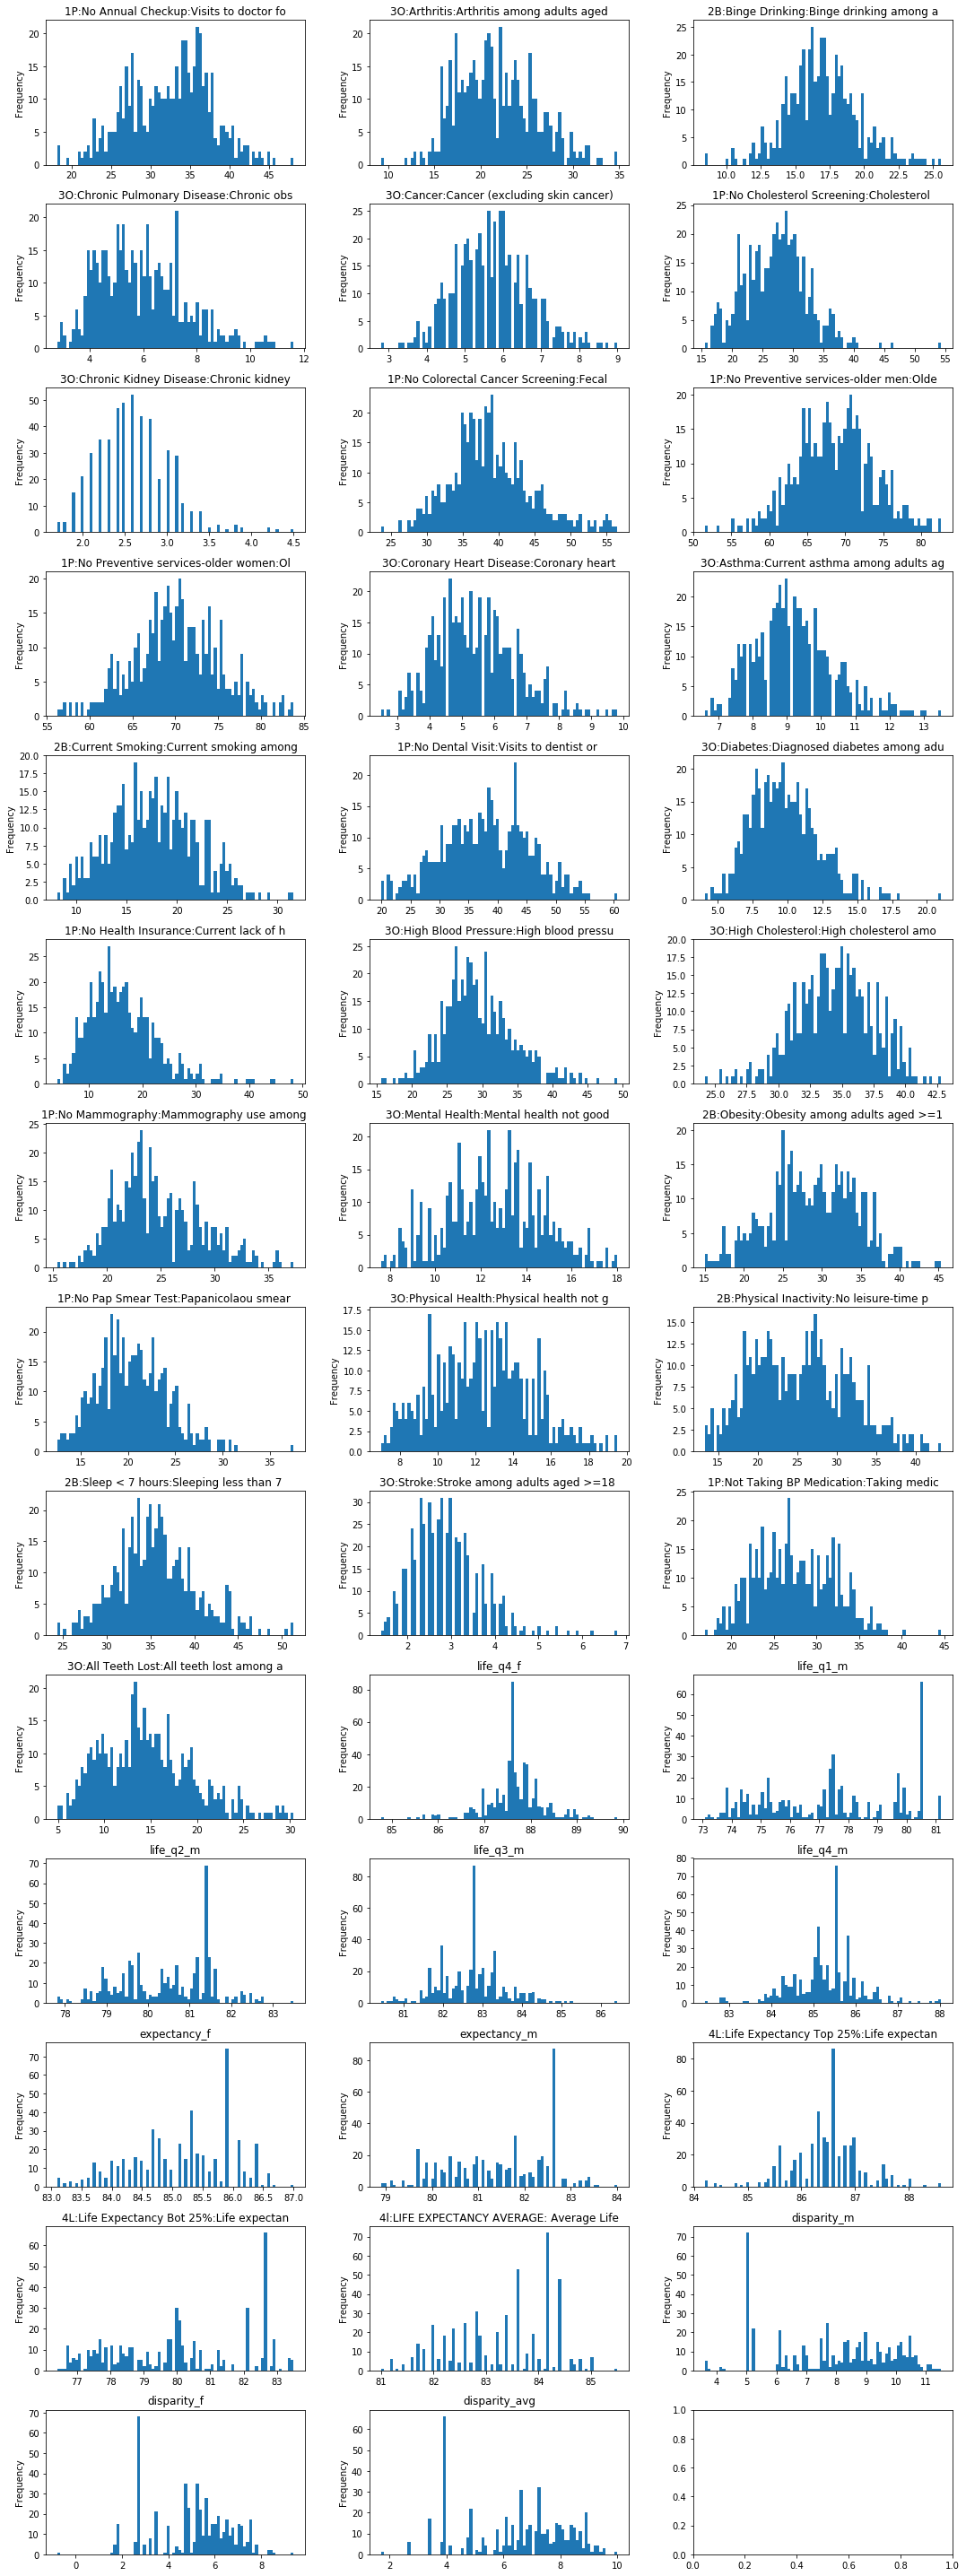

In [9]:
cols = np.append(total.columns[2:30].values, total.columns[46:59].values )

fig, axes = plt.subplots(nrows=14,ncols=3, figsize=(15,40))
for i, col in enumerate(cols):
    ax = axes[i//3,i%3]
    _ = ax.set_title(col[:40])
    _ = total.loc[:, col].plot(kind='hist', bins=80, ax=ax)
#     _ = total.loc[:, col].plot(kind='density',  ax=ax)
_ = plt.tight_layout()

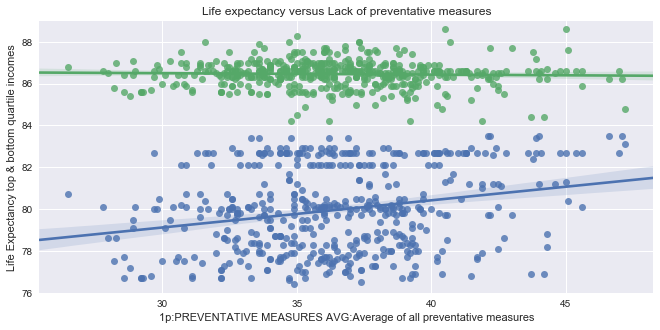

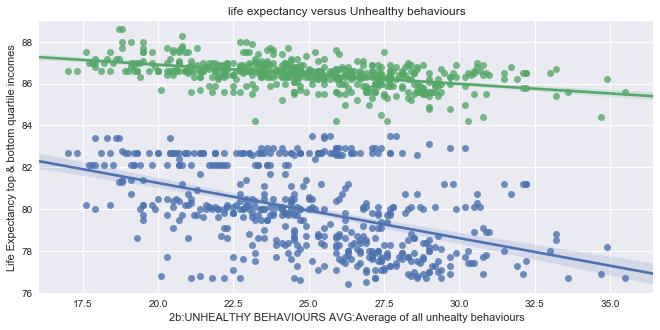

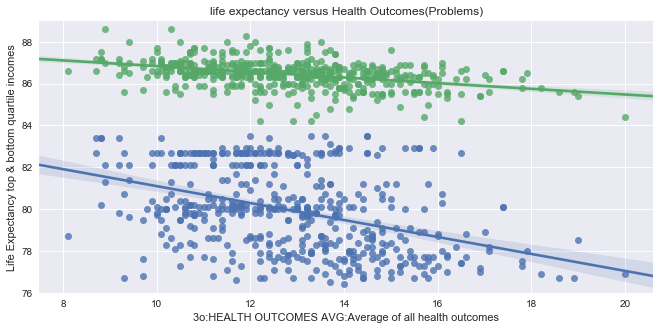

In [10]:
import seaborn as sns
_ = sns.set(rc={'figure.figsize':(11,5)})
        
_ = sns.regplot(x='1p:PREVENTATIVE MEASURES AVG:Average of all preventative measures', y='4L:Life Expectancy Bot 25%:Life expectancy in years, Bottom Quartile Income', data=total)
_ = sns.regplot(x='1p:PREVENTATIVE MEASURES AVG:Average of all preventative measures', y='4L:Life Expectancy Top 25%:Life expectancy in years, Top Quartile Income', data=total)
_ = plt.ylabel('Life Expectancy top & bottom quartile incomes')
_ = plt.ylim((76,89))
_ = plt.title('Life expectancy versus Lack of preventative measures')
_ = plt.show()

_ = sns.regplot(x='2b:UNHEALTHY BEHAVIOURS AVG:Average of all unhealty behaviours', y='4L:Life Expectancy Bot 25%:Life expectancy in years, Bottom Quartile Income', data=total)
_ = sns.regplot(x='2b:UNHEALTHY BEHAVIOURS AVG:Average of all unhealty behaviours', y='4L:Life Expectancy Top 25%:Life expectancy in years, Top Quartile Income', data=total)
_ = plt.title('life expectancy versus Unhealthy behaviours')
_ = plt.ylabel('Life Expectancy top & bottom quartile incomes')
_ = plt.ylim((76,89))
_ = plt.show()

_ = sns.regplot(x='3o:HEALTH OUTCOMES AVG:Average of all health outcomes', y='4L:Life Expectancy Bot 25%:Life expectancy in years, Bottom Quartile Income', data=total)
_ = sns.regplot(x='3o:HEALTH OUTCOMES AVG:Average of all health outcomes', y='4L:Life Expectancy Top 25%:Life expectancy in years, Top Quartile Income', data=total)
_ = plt.title('life expectancy versus Health Outcomes(Problems)')
_ = plt.ylabel('Life Expectancy top & bottom quartile incomes')
_ = plt.ylim((76,89))
_ = plt.show()

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
cols = ['StateDesc','CityName', 'PopulationCount', 'health_score', 'expectancy_f', 'expectancy_m', 
        '4L:Life Expectancy Top 25%:Life expectancy in years, Top Quartile Income',
        '4L:Life Expectancy Bot 25%:Life expectancy in years, Bottom Quartile Income',
        '4l:LIFE EXPECTANCY AVERAGE: Average Life Expectancy in Years', 'disparity_avg', 
        '1p:PREVENTATIVE MEASURES AVG:Average of all preventative measures',
        '2b:UNHEALTHY BEHAVIOURS AVG:Average of all unhealty behaviours',
        '3o:HEALTH OUTCOMES AVG:Average of all health outcomes',
       ]
temp = total[cols].groupby('StateDesc').mean()
temp.sort_values('disparity_avg',ascending=False)

In [ ]:
cols = ['CityName', 'StateDesc', 'PopulationCount', 'health_score', 'expectancy_f', 'expectancy_m', 
        '4L:Life Expectancy Top 25%:Life expectancy in years, Top Quartile Income',
        '4L:Life Expectancy Bot 25%:Life expectancy in years, Bottom Quartile Income',
        '4l:LIFE EXPECTANCY AVERAGE: Average Life Expectancy in Years', 'disparity_avg', 
        '1p:PREVENTATIVE MEASURES AVG:Average of all preventative measures',
        '2b:UNHEALTHY BEHAVIOURS AVG:Average of all unhealty behaviours',
        '3o:HEALTH OUTCOMES AVG:Average of all health outcomes',
       ]

temp = total.sort_values('3O:All Teeth Lost:All teeth lost among adults aged >=65 Years',ascending=False)
temp.head()
temp.tail()

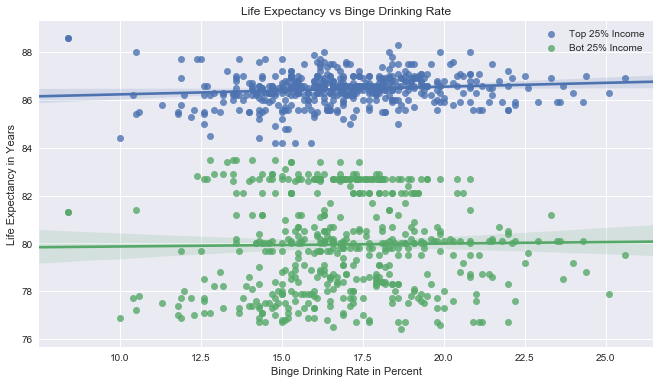

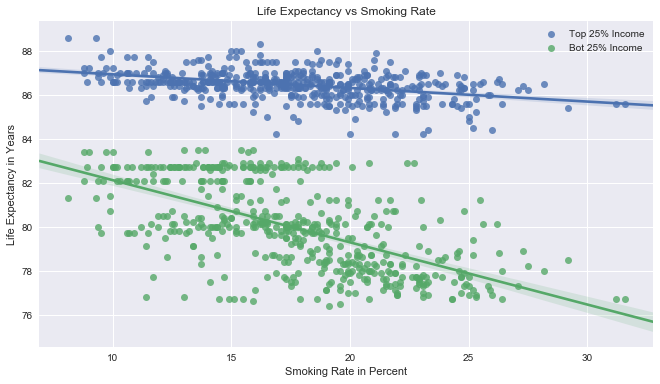

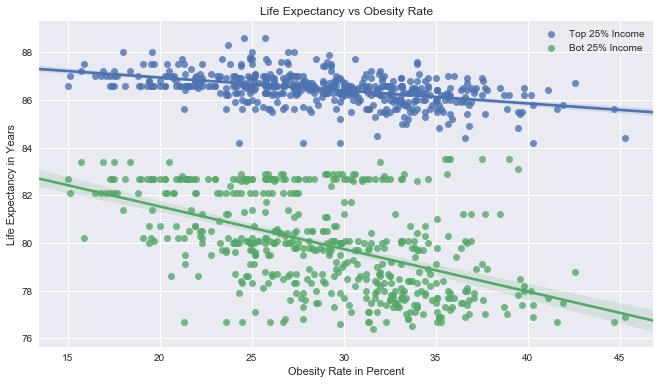

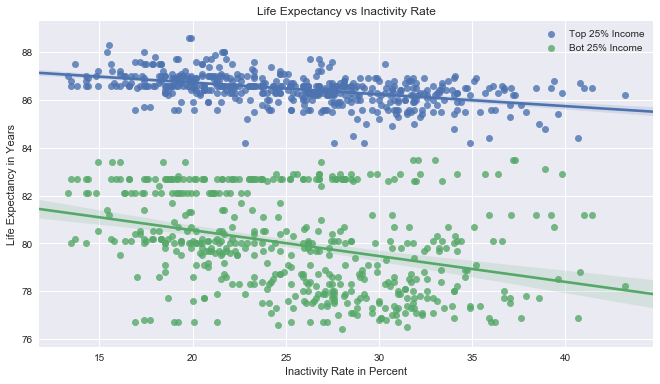

In [14]:
import seaborn as sns

_ = sns.set(rc={'figure.figsize':(11,6)})
graphs = {'Binge Drinking Rate': '2B:Binge Drinking:Binge drinking among adults aged >=18 Years',
          'Smoking Rate':'2B:Current Smoking:Current smoking among adults aged >=18 Years',
          'Obesity Rate':'2B:Obesity:Obesity among adults aged >=18 Years',
          'Inactivity Rate':'2B:Physical Inactivity:No leisure-time physical activity among adults aged >=18 Years',
         }

for graph in graphs:
    _ = sns.regplot(x=graphs[graph], label='Top 25% Income',
                    y='4L:Life Expectancy Top 25%:Life expectancy in years, Top Quartile Income', data=total)
    _ = sns.regplot(x=graphs[graph], label='Bot 25% Income',
                    y='4L:Life Expectancy Bot 25%:Life expectancy in years, Bottom Quartile Income', data=total)
    _ = plt.title('Life Expectancy vs ' + graph)
    _ = plt.ylabel('Life Expectancy in Years')
    _ = plt.xlabel(graph + ' in Percent')
    _ = plt.legend()
    _ = plt.show()

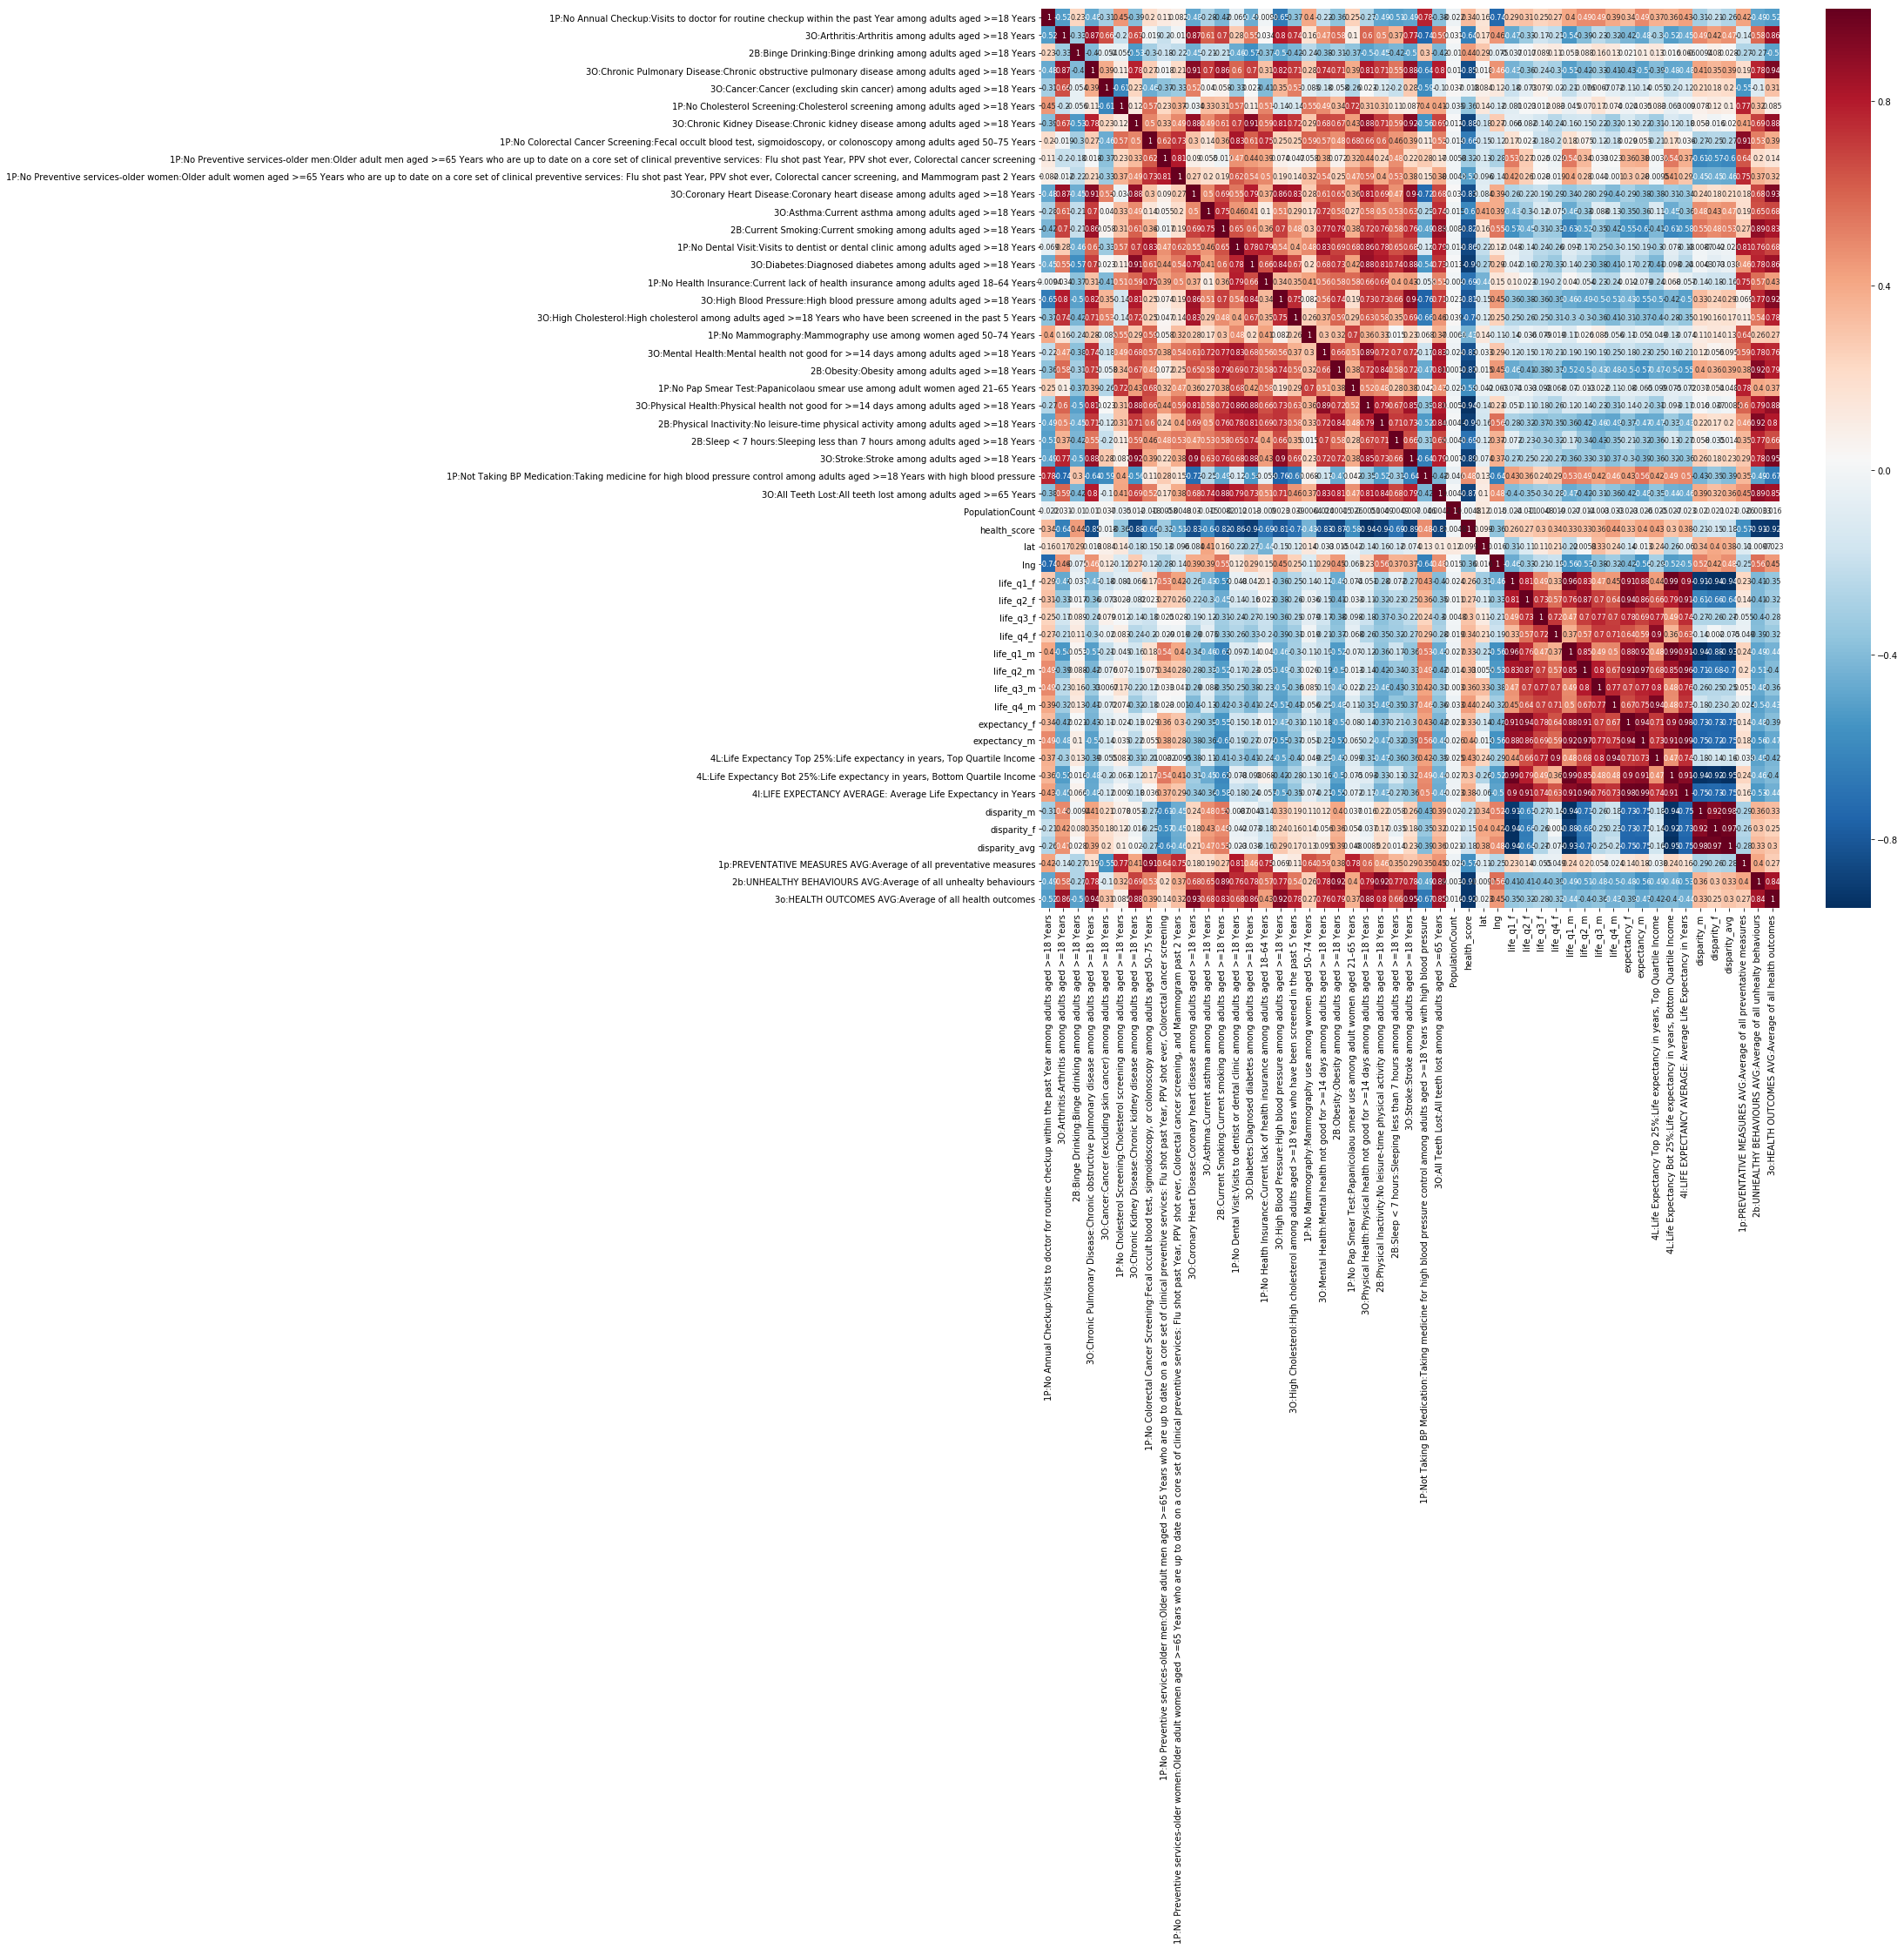

In [12]:
dfcorr = total.corr()
_ = plt.figure(figsize=(19,19))
_ = sns.heatmap(dfcorr, annot=True, cmap='RdBu_r', annot_kws={"size": 8})